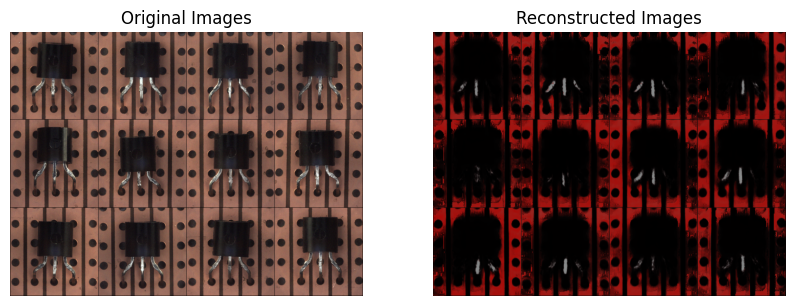

: 

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from load_dataset import CustomDataset
import torchvision
import numpy as np

def unnormalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """표준화된 이미지 텐서를 원래의 값으로 역정규화합니다."""
    if image_tensor.is_cuda:
        mean = torch.tensor(mean, device=image_tensor.device).view(3, 1, 1)
        std = torch.tensor(std, device=image_tensor.device).view(3, 1, 1)
    else:
        mean = torch.tensor(mean).view(3, 1, 1)
        std = torch.tensor(std).view(3, 1, 1)
    
    # 표준화된 값을 원래의 값으로 역변환합니다.
    image_tensor = image_tensor * std + mean
    # 이미지의 픽셀 값 범위를 [0, 1]로 제한합니다.
    image_tensor = torch.clamp(image_tensor, 0, 1)
    return image_tensor

def get_train_loader(csv_file, batch_size, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),                  # x -> [0,1] normalize
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # transforms.Grayscale(num_output_channels=1)
    ])

    train_data = CustomDataset(csv_file=csv_file, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    return train_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.jit.load('./model_files/deepSVDD/C_AE_gpu_z_64.pt', map_location=torch.device('cpu'))
model.eval()  

train_loader = get_train_loader('./datas/train.csv', 16) 
images, _ = next(iter(train_loader))
images = images.to(device)

with torch.no_grad(): 
    reconstructed = model(images)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

images = unnormalize(images)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(torchvision.utils.make_grid(images.cpu().data[:12], nrow=4))
plt.title('Original Images')


# reconstructed = unnormalize(reconstructed)
plt.subplot(1, 2, 2)
imshow(torchvision.utils.make_grid(reconstructed.cpu().data[:12], nrow=4))
plt.title('Reconstructed Images')

plt.show()

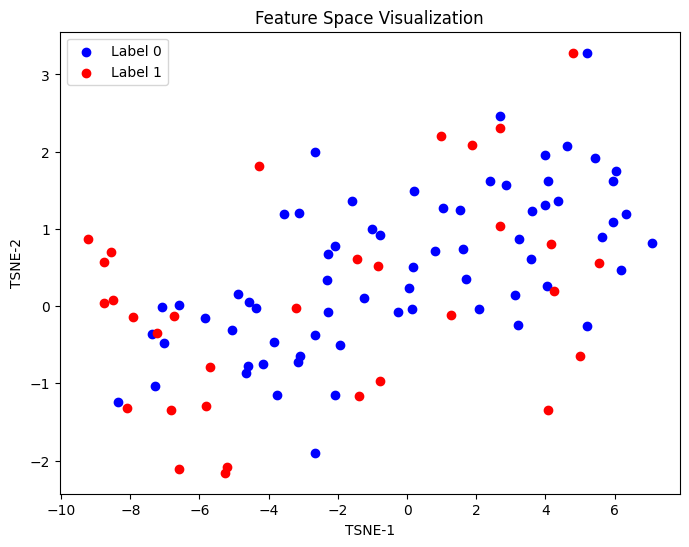

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join('./datas', self.df['img_path'].iloc[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        target = torch.tensor([0.]).float()
        label = self.df['label'].iloc[idx]
        # return image, target
        return image, label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.jit.load('./model_files/deepSVDD/v1_gpu.pt', map_location=torch.device('cpu'))
model.eval()  

def get_train_loader(csv_file, batch_size, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        # transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),                  # x -> [0,1] normalize
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_data = CustomDataset(csv_file=csv_file, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    return train_loader


def get_features_from_model(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data in loader:
            inputs, label = data
            feature = model(inputs)
            feature = feature.view(feature.size(0), -1)
            features.append(feature)
            labels.append(label)
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

# 데이터 로더 생성
train_loader = get_train_loader(csv_file='./datas/test.csv', batch_size=64)

# 특성 추출
features, labels = get_features_from_model(model, train_loader)

# 차원 축소 및 시각화
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features_numpy = features.detach().numpy() 

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features_numpy)

labels_numpy = labels.detach().numpy().flatten() 

plt.figure(figsize=(8, 6))

plt.scatter(features_2d[labels_numpy == 0, 0], features_2d[labels_numpy == 0, 1], c='blue', label='Label 0')

plt.scatter(features_2d[labels_numpy == 1, 0], features_2d[labels_numpy == 1, 1], c='red', label='Label 1')

plt.title('Feature Space Visualization')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend()
plt.show()

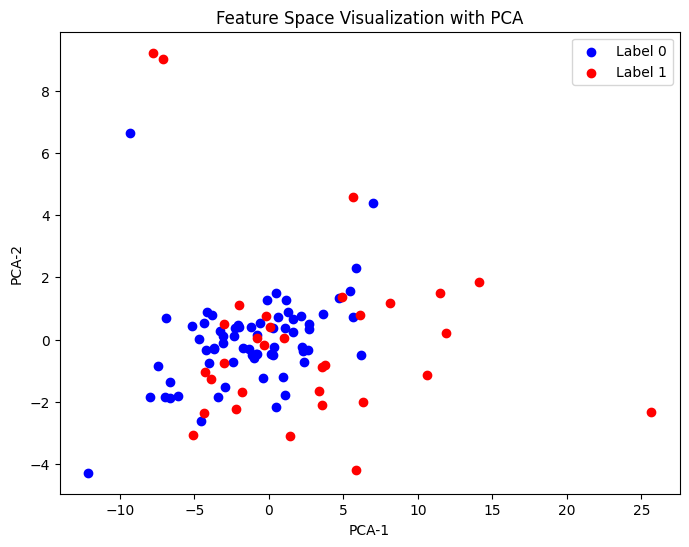

In [3]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join('./datas', self.df['img_path'].iloc[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        target = torch.tensor([0.]).float()
        label = self.df['label'].iloc[idx]
        # return image, target
        return image, label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.jit.load('./model_files/deepSVDD/v1_gpu.pt', map_location=torch.device('cpu'))
model.eval()  

def get_train_loader(csv_file, batch_size, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        # transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),                  # x -> [0,1] normalize
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_data = CustomDataset(csv_file=csv_file, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    return train_loader


def get_features_from_model(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data in loader:
            inputs, label = data
            feature = model(inputs)
            feature = feature.view(feature.size(0), -1)
            features.append(feature)
            labels.append(label)
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

# 데이터 로더 생성
train_loader = get_train_loader(csv_file='./datas/test.csv', batch_size=64)

# 특성 추출
features, labels = get_features_from_model(model, train_loader)

# 차원 축소 및 시각화

import matplotlib.pyplot as plt

features_numpy = features.detach().numpy() 

from sklearn.decomposition import PCA

# TSNE 대신 PCA 사용
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_numpy)

labels_numpy = labels.detach().numpy().flatten()

plt.figure(figsize=(8, 6))

plt.scatter(features_2d[labels_numpy == 0, 0], features_2d[labels_numpy == 0, 1], c='blue', label='Label 0')
plt.scatter(features_2d[labels_numpy == 1, 0], features_2d[labels_numpy == 1, 1], c='red', label='Label 1')

plt.title('Feature Space Visualization with PCA')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend()
plt.show()